# Notebook de nettoyage
## Adrian Rodriguez
## Projet 4 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

In [1]:
import pandas as pd
pd.options.display.max_columns = None

import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.sklearn

from wordcloud import WordCloud
import PIL.Image
import en_core_web_sm
import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS

pd.options.display.max_columns = None
plt.style.use("default")
from functions import *

---
# 1. Importation et exploration préliminaire
Les données ont été extraite du site stackexchangeexplorer. J'ai traité des post récents.    
Requête SQL : 
```     
DECLARE @max_date as DATETIME = DATEADD(MONTH, -1, GETDATE())

SELECT Id, Title, Body, Tags    
FROM posts
WHERE CreationDate < @max_date AND PostTypeId = 1 AND Score > 19
ORDER BY CreationDate DESC
```

Les données ont été stockées dans le fichiser 'QueryResults.csv'.

In [ ]:
questions_raw = pd.read_csv('src/Questions50K_QueryResults.csv')

In [4]:
questions_raw.head()

,Id,Title,Body,Tags
0,63087217,Changes using mutable reference of a field are...,<p>I was trying to manipulate the field <code>...,<rust><reference><move>
1,63078532,Is it possible to create a new data type in Ja...,<p>Is it possible to create a new data type in...,<javascript>
2,63067062,Elastic Search indexes gets deleted frequently,<p>I'm running an elastic search for a persona...,<elasticsearch>
3,63046397,Why does this usage of C++17 if constexpr fail?,<p>I am trying to use C++17 <code>if constexpr...,<c++><if-statement><templates><c++17><constexpr>
4,63043585,"VSCode showing ""Java 11 or more recent is requ...",<p>VSCode started showing me today a pop-up sa...,<java><visual-studio-code>


In [5]:
questions_raw.shape

(50000, 4)

In [6]:
questions_raw.columns

Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')

In [7]:
questions_raw.isna().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [8]:
questions = questions_raw.copy()

# 2. Exploration des tags associés aux questions
Je cherche à connaître quels sont les tags les plus utilisés et à savoir

In [9]:
questions.Tags = questions.Tags.apply(lambda x: x.replace('<', '').replace('>', ' ')).str.split()
tags = questions.Tags.explode().reset_index()
tags = tags.groupby('Tags').count().sort_values(by='index', ascending=False).reset_index().rename(columns={'index': 'recurrence'})
print(f'Nous avons {len(tags)} tags utilisés sur la période')

Nous avons 10573 tags utilisés sur la période


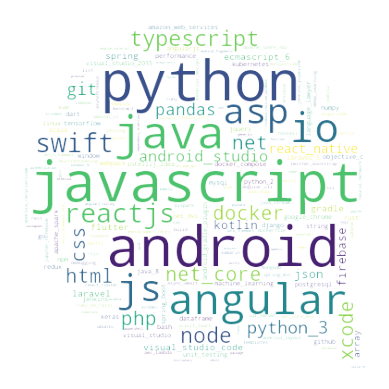

In [10]:
tags.Tags = tags.Tags.str.replace('-', '_')
text = (tags.Tags + ' ') * tags['recurrence']
text = ''.join(text)

# Création de l'objet
mask = np.array(PIL.Image.open('src/bulle.jpg'))
wordcloud = WordCloud(width=1200, height=780, background_color="rgba(255, 255, 255, 0)", mode="RGBA", collocations=False, mask=mask).generate(text)
 
# Génération de l'image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

plt.savefig('img/img_wordcloud_tags.png',
            transparent=True,
            bbox_inches="tight")

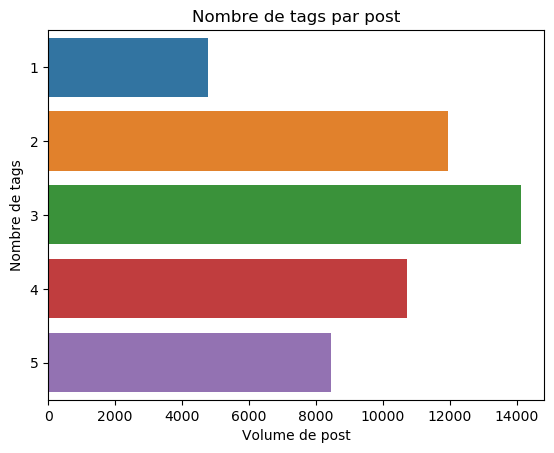

In [11]:
tags_count = questions.Tags.apply(lambda x: len(x)).reset_index()
tags_count = tags_count.groupby('Tags').count().reset_index()

plt.clf()
sns.barplot(y='Tags',
            x='index',
            data=tags_count,
            orient='h')
plt.title('Nombre de tags par post')
plt.xlabel('Volume de post')
plt.ylabel('Nombre de tags')

plt.savefig('img/img_tags_count.png',
            transparent=True,
            bbox_inches="tight")

80 % du volume des tags est expliqué par 969 tags soit une proportion de 9.0 % de la population des tags


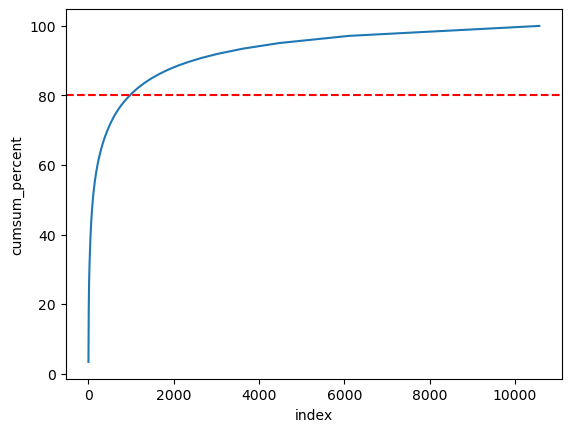

In [12]:
tags_imp = (tags['recurrence'].cumsum() / tags['recurrence'].sum()) * 100
tags_imp = tags_imp.reset_index().rename(columns={'recurrence': 'cumsum_percent'})

vol_treshold = 80
qty_tags = len(tags_imp[tags_imp.cumsum_percent < vol_treshold])
vol_qty_tags = round(qty_tags / len(tags_imp) * 100, 0)
print(f'{vol_treshold} % du volume des tags est expliqué par {qty_tags} tags soit une proportion de {vol_qty_tags} % de la population des tags')

sns.lineplot(x='index', y='cumsum_percent', data=tags_imp)
plt.axhline(y=vol_treshold, color='red', linestyle='--')
plt.show()

In [13]:
bag_tags = tags.head(qty_tags)
bag_tags.tail(10)

,Tags,recurrence
959,pom.xml,20
960,pyspark_sql,20
961,socket.io,20
962,pipe,20
963,angularfire2,20
964,meteor,20
965,integration_testing,20
966,angular2_http,20
967,winapi,20
968,f_string,20


Les tags les moins souvent utilisés l'ont été au moins 20 fois sur des sujets reconnus et pertinents

In [14]:
bag_tags_lst = bag_tags.Tags.to_list()

In [15]:
[display(bag_tags[bag_tags.Tags == i]) for i in bag_tags_lst if i in STOP_WORDS]

,Tags,recurrence
61,go,366


,Tags,recurrence
724,this,27


[None, None]

In [16]:
bag_tags_lst.remove('go')
bag_tags_lst.remove('this')

In [17]:
display('go' in bag_tags_lst)
display('this' in bag_tags_lst)

False

False

# 3.Exploration des champs texte

En procédant à un test maison, je me rends facilement compte que je peux mettre des informations importante soit dans le titre, soit dans le body. Je ne pense pas forcément à les mettre dans les 2 blocs. De ce fait, je dois analyser le champs `Body` et le champs `Title`.

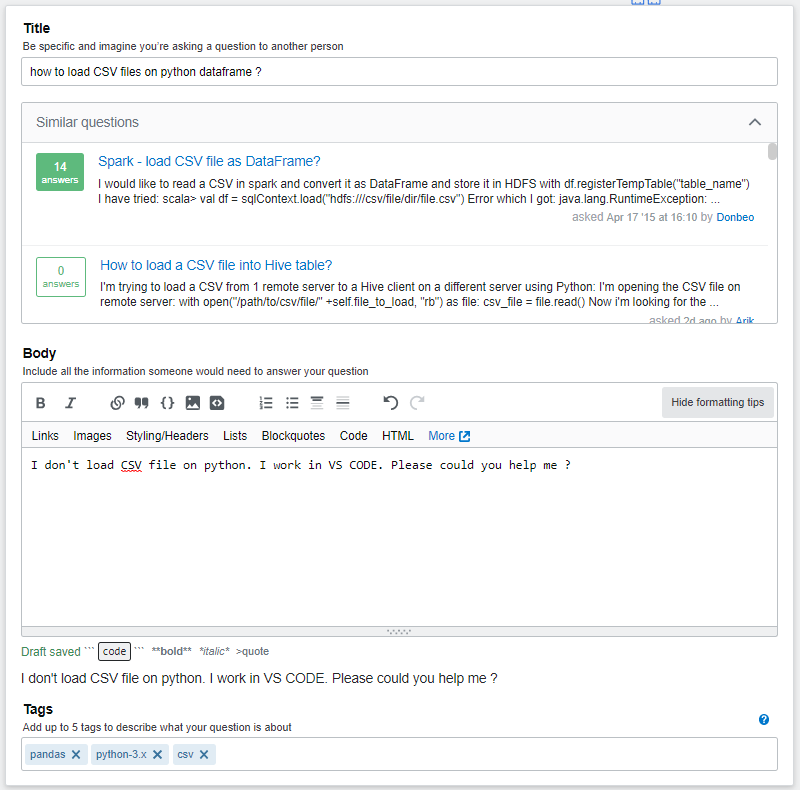

In [18]:
Image('src/post.png')

In [19]:
questions['Title_Body'] = questions.Title + ' ' + questions.Body
questions

,Id,Title,Body,Tags,Title_Body
0,63087217,Changes using mutable reference of a field are...,<p>I was trying to manipulate the field <code>...,"[rust, reference, move]",Changes using mutable reference of a field are...
1,63078532,Is it possible to create a new data type in Ja...,<p>Is it possible to create a new data type in...,[javascript],Is it possible to create a new data type in Ja...
2,63067062,Elastic Search indexes gets deleted frequently,<p>I'm running an elastic search for a persona...,[elasticsearch],Elastic Search indexes gets deleted frequently...
3,63046397,Why does this usage of C++17 if constexpr fail?,<p>I am trying to use C++17 <code>if constexpr...,"[c++, if-statement, templates, c++17, constexpr]",Why does this usage of C++17 if constexpr fail...
4,63043585,"VSCode showing ""Java 11 or more recent is requ...",<p>VSCode started showing me today a pop-up sa...,"[java, visual-studio-code]","VSCode showing ""Java 11 or more recent is requ..."
...,...,...,...,...,...
49995,29895387,Service workers and iOS / Safari,<p>On Chromium's page about service workers th...,"[ios, service-worker, progressive-web-apps]",Service workers and iOS / Safari <p>On Chromiu...
49996,29894997,Prevent iOS bounce without disabling scroll ab...,<p>I am trying to implement a solution to prev...,"[javascript, jquery, html, ios, css]",Prevent iOS bounce without disabling scroll ab...
49997,29894781,Javascript selected text highlighting prob,<p>I have a html page with text content. On se...,"[javascript, getselection]",Javascript selected text highlighting prob <p>...
49998,29894749,Complete list of iOS app permissions,"<p>Different web sites (<a href=""http://www.ho...","[ios, permissions, ios-permissions]",Complete list of iOS app permissions <p>Differ...


# 4. NLP Pipeline

In [20]:
# Je limite le nombre d'observation pour la phase de dev
questions = questions.head(10000)

## Traitement avant taggage POS

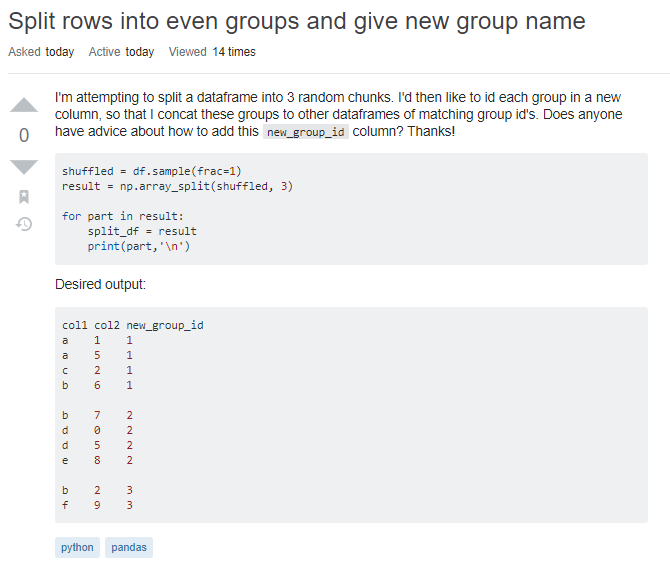

In [21]:
Image('src/question.png')

Lorsque j'analyse une question. Je constate qu'il peut y avoir des blocs de codes, et des blocs d'image. Ces blocs génèrent du bruit et n'apporte pas de ou très peu de valeurs ajoutées au sens de la question. Je décide de les retirer. Les blocs de code non préformaté ne peuvent pas être retiré.

Je retire également les tags HTML, les retours ligne \n, les éventuels caractères accentués et je passe tous les caractères en minuscule s'il ne le sont pas déjà.

Je constate aussi qu'il peut y avoir des formes contractées des verbes. Ces verbes peuvent être important pour le sens de la phrase. Je souhaite uniformiser tout cela.

Pour ce projet, je n'ai pas besoin de la reconnaissance de nom (NER), je désactive ce composant.

In [22]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])

nlp.add_pipe(CleanBeforeTaggerComponent(nlp), first=True)
nlp.add_pipe(ContractionsComponent(nlp), after='CleanBeforeTagger')

print('Pipeline:', nlp.pipe_names)

Pipeline: ['CleanBeforeTagger', 'Contractions', 'tagger', 'parser']


## Traitement après parser (.dep_)

In [23]:
questions.Title_Body[3]

'Why does this usage of C++17 if constexpr fail? <p>I am trying to use C++17 <code>if constexpr</code> for conditional compilation, but it does not behave the way I expect.</p>\n<p>For example, with the code below, C++ still compiles the code defined by the macro <code>X2</code>,</p>\n<pre><code>#include &lt;map&gt;\n#include &lt;string&gt;\n#include &lt;iostream&gt;\n#include &lt;type_traits&gt;\n\n#define X1 pp(&quot;x&quot;)\n#define X2 pp(&quot;x&quot;, &quot;x&quot;)\n\nvoid pp(const std::string str)\n{\n   std::cout &lt;&lt; str &lt;&lt; std::endl;\n}\n\nint main()\n{\n   std::map&lt;std::string, int&gt; map;\n\n   if constexpr (std::is_null_pointer_v&lt;decltype(map)&gt;)\n      X2;\n   else\n      X1;\n}\n</code></pre>\n<p>and spits out this error messages:</p>\n<pre class="lang-none prettyprint-override"><code>1.c:6:23: error: too many arguments to function ‘void pp(std::__cxx11::string)’\n #define X2 pp(&quot;x&quot;, &quot;x&quot;)\n                       ^\n1.c:18:3: note: 

In [24]:
doc = nlp(questions.Title_Body[3])

In [25]:
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head)

why ADV ROOT why
does AUX aux why
this DET det usage
usage NOUN dobj does
of ADP prep usage
c++17 NOUN pobj of
if SCONJ mark fail
constexpr NOUN advmod fail
fail VERB advcl does
? PUNCT punct does
i PRON nsubj trying
am AUX aux trying
trying VERB ROOT trying
to PART aux use
use VERB xcomp trying
c++17 NOUN dobj use
if SCONJ mark constexpr
constexpr NOUN advcl use
for ADP prep use
conditional ADJ amod compilation
compilation NOUN pobj for
, PUNCT punct trying
but CCONJ cc trying
it PRON nsubj behave
does AUX aux behave
not PART neg behave
behave VERB conj trying
the DET det way
way NOUN dobj behave
i PRON nsubj expect.for
expect.for ADP relcl way
example NOUN dobj expect.for
, PUNCT punct behave
with ADP prep behave
the DET det code
code NOUN pobj with
below ADV advmod code
, PUNCT punct compiles
c++ PROPN nsubj compiles
still ADV advmod compiles
compiles VERB conj behave
the DET det code
code NOUN dobj compiles
defined VERB acl code
by ADP agent defined
the DET det x2,and
macro ADJ com

Les mots qui sont présent à la racine (ROOT) d'une phrase sont très importants. Ils donnent le sens à la question. De ce fait je dois les conserver. De même pour les noms (NOUN). Je conserve également les mots qui sont présents dans la liste de tags.

Je conserve les versions lemmatisées des mots.

Cette structure me permet de garder un sens à la phrase et les principaux mots-clés.

In [26]:
full_txt = [token.text for token in doc]
txt = [token.lemma_ for token in doc
        if ((token.dep_ == 'ROOT' or
        token.pos_ == 'NOUN' or
        token.pos_ == 'ADJ' or
        token.pos_ == 'ADV') and
        token.text not in STOP_WORDS) or
        token.text in bag_tags_lst]

full_txt = ' '.join(full_txt)
txt = ' '.join(txt)

print(f'Texte avant nettoyage : \n{full_txt}\n\nTexte après nettoyage : \n{txt}')

Texte avant nettoyage : 
why does this usage of c++17 if constexpr fail ? i am trying to use c++17 if constexpr for conditional compilation , but it does not behave the way i expect.for example , with the code below , c++ still compiles the code defined by the macro x2,and spits out this error messages : how can i skip compilation of x2 ?

Texte après nettoyage : 
usage c++17 constexpr try c++17 constexpr conditional compilation way example code c++ code macro error message compilation


In [27]:
clean = CleanAfterParserComponent(nlp)
clean.set_protect(bag_tags_lst)
nlp.add_pipe(clean, after='parser')

print('Pipeline:', nlp.pipe_names)

Pipeline: ['CleanBeforeTagger', 'Contractions', 'tagger', 'parser', 'CleanAfterParser']


pas de stemmization 

'access',
 'access_token',
 'accessi',
 'accessibility',
 'accessibilitybundle',
 'accessibilityinfo',
 'accessible',
 'accessor',
 'accessorily',
 'accessory',
 'accessright',

## Vérification

In [28]:
questions.NLP_Title_Body = questions.Title_Body.apply(lambda x: nlp(x))

In [29]:
questions.NLP_Title_Body = questions.NLP_Title_Body.astype(str)

In [30]:
display(questions_raw['Title'][5])
display(questions_raw['Body'][5])

'Why is __int128_t faster than long long on x86-64 GCC?'

'<p>This is my test code:</p>\n<pre class="lang-cpp prettyprint-override"><code>#include &lt;chrono&gt;\n#include &lt;iostream&gt;\n#include &lt;cstdlib&gt;\nusing namespace std;\n\nusing ll = long long;\n\nint main()\n{\n    __int128_t a, b;\n    ll x, y;\n\n    a = rand() + 10000000;\n    b = rand() % 50000;\n    auto t0 = chrono::steady_clock::now();\n    for (int i = 0; i &lt; 100000000; i++)\n    {\n        a += b;\n        a /= b;\n        b *= a;\n        b -= a;\n        a %= b;\n    }\n    cout &lt;&lt; chrono::duration_cast&lt;chrono::milliseconds&gt;(chrono::steady_clock::now() - t0).count() &lt;&lt; \' \'\n         &lt;&lt; (ll)a % 100000 &lt;&lt; \'\\n\';\n\n    x = rand() + 10000000;\n    y = rand() % 50000;\n    t0 = chrono::steady_clock::now();\n    for (int i = 0; i &lt; 100000000; i++)\n    {\n        x += y;\n        x /= y;\n        y *= x;\n        y -= x;\n        x %= y;\n    }\n    cout &lt;&lt; chrono::duration_cast&lt;chrono::milliseconds&gt;(chrono::steady_cl

In [31]:
questions.NLP_Title_Body[5]

'int128_t fast long long x86 gcc test code test result gcc linux matter optimization int128_t little fast long double significantly fast long long long long slow happen'

In [32]:
questions.NLP_Title_Body.head(20)

0     change mutable reference field reflect origina...
1     possible new data type javascript possible new...
2     elastic search index delete frequently elastic...
3     usage c++17 constexpr try c++17 constexpr cond...
4     java recent require download recent jdk start ...
5     int128_t fast long long x86 gcc test code test...
6     discord.py random error typeerror new _ unexpe...
7     bigint inconsistency powershell c # bigint dat...
8     implicit conversion work java java integer lit...
9     inspect element find result yellow usual test ...
10    prevent chrome download recent update chrome b...
11    need module java currently migrate java java s...
12    niebloid c++20 read term niebloid cppreference...
13    disable issue tab console way issue tab chrome...
14    equality appear symmetric relation python lear...
15    modify field variable lead unexpected behavior...
16    dev tool break warning create react app browse...
17    efficient way value data frame panda dataf

In [33]:
tokens = token_text(' '.join(questions.NLP_Title_Body))
Counter(tokens).most_common(30)

[('error', 5287),
 ('code', 3975),
 ('file', 3189),
 ('way', 2473),
 ('function', 2390),
 ('project', 2284),
 ('version', 2268),
 ('new', 2154),
 ('app', 2114),
 ('type', 2069),
 ('android', 1910),
 ('try', 1895),
 ('value', 1854),
 ('example', 1709),
 ('problem', 1678),
 ('class', 1641),
 ('method', 1595),
 ('build', 1560),
 ('question', 1462),
 ('time', 1388),
 ('use', 1376),
 ('work', 1364),
 ('angular', 1344),
 ('set', 1325),
 ('component', 1321),
 ('issue', 1320),
 ('test', 1276),
 ('object', 1248),
 ('datum', 1224),
 ('user', 1143)]

---
---

# 5. Classification non supervisée
Méthode : 
- 1/ Création du vecteur de mots
- 2/ Calcul du nombre de sujet idéal
- 3/ Formation du modèle
- 4/ Vérification des résultats

In [34]:
corpus = questions.NLP_Title_Body

## Création du vecteur de mots

In [314]:
count_vectorizer = CountVectorizer()
# tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

# calculate the feature matrix
feature_matrix = count_vectorizer.fit_transform(corpus)
# tfidf_feature_matrix = tfidf_vectorizer.fit_transform(corpus)

display(feature_matrix.shape)
# display(tfidf_feature_matrix.shape)

(10000, 20353)

## Détermination du nombre de sujet idéal

In [258]:
results = pd.DataFrame()
tmp_result = pd.DataFrame(index = range(1))
for i in np.arange(5, 70, 5):
    print(f'{i} composants en cours de traitement...')
    lda_model = LatentDirichletAllocation(n_components=i, random_state=123)

    lda_model.fit_transform(feature_matrix)

    tmp_result['n_components'] = i
    tmp_result['log_likelihood'] = lda_model.score(feature_matrix)
    tmp_result['perplexity'] = lda_model.perplexity(feature_matrix)

    results = results.append(tmp_result)

results

5 composants en cours de traitement...
10 composants en cours de traitement...
15 composants en cours de traitement...
20 composants en cours de traitement...
25 composants en cours de traitement...
30 composants en cours de traitement...
35 composants en cours de traitement...
40 composants en cours de traitement...
45 composants en cours de traitement...
50 composants en cours de traitement...
55 composants en cours de traitement...
60 composants en cours de traitement...
65 composants en cours de traitement...


,n_components,log_likelihood,perplexity
0,5,-2.672466e+06,1820.799713
0,10,-2.673128e+06,1824.189340
0,15,-2.666520e+06,1790.640856
0,20,-2.669607e+06,1806.236672
0,25,-2.672728e+06,1822.143823
0,30,-2.671419e+06,1815.456202
0,35,-2.675996e+06,1838.946575
0,40,-2.679729e+06,1858.330978
0,45,-2.678335e+06,1851.070234
0,50,-2.686320e+06,1893.058846


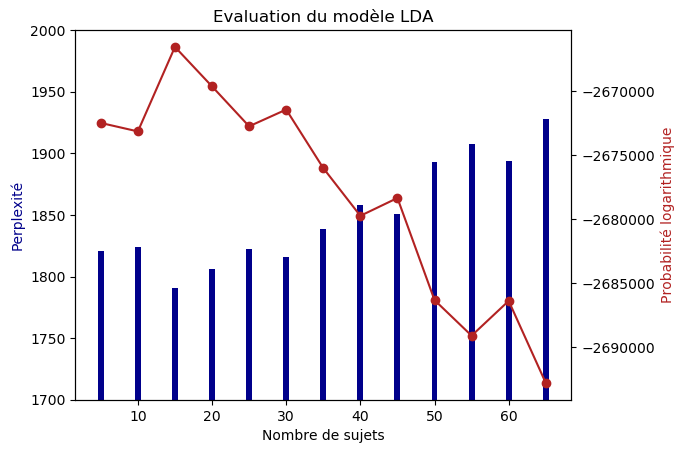

In [327]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(results.n_components,
        results.perplexity,
        color='darkblue')
ax2.plot(results.n_components,
         results.log_likelihood,
         'o-',
         color="firebrick")
min_y = int(results.perplexity.min()/100)*100
max_y = int((results.perplexity.max()+100)/100)*100
ax1.set_ylim(min_y, max_y)
ax1.set_xlabel('Nombre de sujets')
ax1.set_ylabel('Perplexité', color='darkblue')
ax2.set_ylabel('Probabilité logarithmique', color='firebrick')
plt.title('Evaluation du modèle LDA')
plt.savefig('img/img_LDA_evaluation.png',
            transparent=True)
plt.show()

Je cherche à avoir la probabilité logarithmique la plus élevée et une moindre perplexité.

## Formation du modèle

In [272]:
min_perp = results.perplexity.min()
n_comp = results[results.perplexity == min_perp].n_components.item()
print(f'Le nombre de sujet idéal est de {n_comp}')
# Je forme le modèle
lda = LatentDirichletAllocation(n_components=n_comp, random_state=123)
lda_out = lda.fit_transform(feature_matrix)

Le nombre de sujet idéal est de 15


In [274]:
# Sujet dominants dans chaque documents
doc_topic = get_doc_topic(lda, corpus, lda_out)
doc_topic

,Topic_#0,Topic_#1,Topic_#2,Topic_#3,Topic_#4,Topic_#5,Topic_#6,Topic_#7,Topic_#8,Topic_#9,Topic_#10,Topic_#11,Topic_#12,Topic_#13,Topic_#14
0,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.65,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.57,0.19,0.00
4,0.00,0.13,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.77,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91
9996,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93,0.00,0.00,0.00
9997,0.01,0.01,0.70,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.21,0.01
9998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00,0.00,0.49,0.00,0.00


<Figure size 640x480 with 0 Axes>

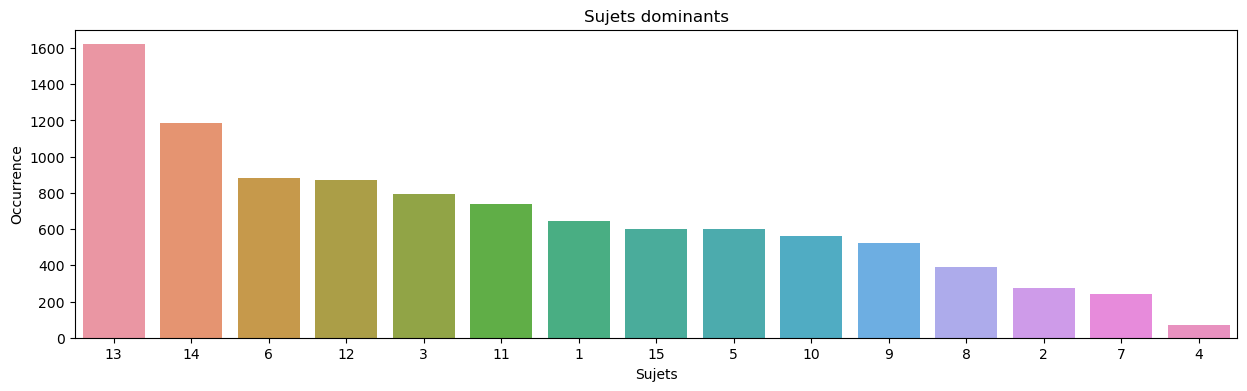

In [275]:
dominant_topic = doc_topic.copy()
dominant_topic['dominant_topic'] = np.argmax(dominant_topic.values, axis=1) + 1
order = dominant_topic.groupby('dominant_topic')['Topic_#1'].count().sort_values(ascending=False).index

plt.clf()
plt.figure(figsize=(15,4))
sns.countplot(dominant_topic.dominant_topic, order=order)
plt.title('Sujets dominants')
plt.xlabel('Sujets')
plt.ylabel('Occurrence')
plt.savefig('img/img_dominant_topic.png',
            transparent=True)

In [276]:
# Top mots clés des différents sujets.
topic_keywords = show_topics(count_vectorizer, lda, 5)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word ' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic_#' + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic_#0,class,method,test,app,kotlin
Topic_#1,state,function,react,component,hook
Topic_#2,file,error,module,import,project
Topic_#3,document,drawable,model,mdpi,new
Topic_#4,request,service,api,error,user
Topic_#5,type,function,value,example,parameter
Topic_#6,string,type,object,code,null
Topic_#7,android,app,device,firebase,firestore
Topic_#8,core,project,net,package,npm
Topic_#9,function,file,test,problem,error


In [ ]:
panel = pyLDAvis.sklearn.prepare(lda, feature_matrix, count_vectorizer, mds='tsne')
pyLDAvis.save_html(panel, 'img/lda.html')
pyLDAvis.display(panel)

## Vérification des résultats
A partir des sujets dominants dans chaque documents et des 5 mots clés principaux de chaque sujets dominants, je consitue une suggestion de tags non supervisée.

In [324]:
pre_out = pd.merge(corpus, questions.Tags, left_index=True, right_index=True)

pred_tag = get_pred_tag(doc_topic, df_topic_keywords, corpus)
out = pd.merge(pre_out, pred_tag, left_index=True, right_index=True)
out

,Title_Body,Tags,pred_tag
0,change mutable reference field reflect origina...,"[rust, reference, move]","type,code,value,function,array"
1,possible new data type javascript possible new...,[javascript],"type,function,value,example,parameter"
2,elastic search index delete frequently elastic...,[elasticsearch],"request,service,api,function,file"
3,usage c++17 constexpr try c++17 constexpr cond...,"[c++, if-statement, templates, c++17, constexpr]","string,code,value,function,error"
4,java recent require download recent jdk start ...,"[java, visual-studio-code]","state,error,build,version,android"
...,...,...,...
9995,send kubernete log cloudwatch cloudwatch log d...,"[amazon-web-services, docker, kubernetes, amaz...","docker,image,python,container,environment"
9996,delete datum xcode instal xcode today morning ...,"[xcode, xcode9]","component,angular,xcode,ios,page"
9997,difference maven url difference maven url buil...,"[java, android, gradle, android-gradle-plugin]","file,error,module,import,build"
9998,function explicit return value control path un...,"[c++, templates, return, code-coverage]","function,file,code,value,array"


In [ ]:
Tags originaux: ('constructor', 'java', 'java-8', 'optional')
Tags non supervisés: type,code,value,function,array
Tags semi supervisés: ('java', 'optional')


---
---

# Classification semi supervisé
Je reprends le modèle réduit avec LDA et mes tags indiqué par l'utilisateur

In [423]:
doc_topic

,Topic_#0,Topic_#1,Topic_#2,Topic_#3,Topic_#4,Topic_#5,Topic_#6,Topic_#7,Topic_#8,Topic_#9,Topic_#10,Topic_#11,Topic_#12,Topic_#13,Topic_#14
0,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.65,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.57,0.19,0.00
4,0.00,0.13,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.77,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91
9996,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93,0.00,0.00,0.00
9997,0.01,0.01,0.70,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.21,0.01
9998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.47,0.00,0.00,0.49,0.00,0.00


In [425]:
out.drop(columns=['Title_Body'])

,Tags,pred_tag
0,"[rust, reference, move]","type,code,value,function,array"
1,[javascript],"type,function,value,example,parameter"
2,[elasticsearch],"request,service,api,function,file"
3,"[c++, if-statement, templates, c++17, constexpr]","string,code,value,function,error"
4,"[java, visual-studio-code]","state,error,build,version,android"
...,...,...
9995,"[amazon-web-services, docker, kubernetes, amaz...","docker,image,python,container,environment"
9996,"[xcode, xcode9]","component,angular,xcode,ios,page"
9997,"[java, android, gradle, android-gradle-plugin]","file,error,module,import,build"
9998,"[c++, templates, return, code-coverage]","function,file,code,value,array"


In [477]:
X_train, X_test, y_train, y_test = train_test_split(doc_topic, out.drop(columns=['Title_Body']), test_size=0.2, random_state=123)

In [478]:
y_train_tag = y_train.drop(columns=['pred_tag'])
y_test_tag = y_test.drop(columns=['pred_tag'])

In [479]:
lst_index = X_test.index.to_list()

## Classification multilabel

In [480]:
mlb = MultiLabelBinarizer()
# Reprise des tags originaux et test de inverse_transform
y_test_tag = mlb.fit_transform(y_test_tag.Tags)
y_test_tag_inversed = mlb.inverse_transform(y_test_tag)

# Mise en place la classification supervisée multilabel
y_train_tag = mlb.fit_transform(y_train_tag.Tags)

In [444]:
# TO DO : Classifier avec KNN, RFF, GB

In [524]:
classifier = [('LogisticRegression', LogisticRegression(C=1, penalty='l1', dual=False, solver='liblinear')),
              ('LinearSVC', LinearSVC(C=1, penalty='l1', dual=False, loss='squared_hinge')), 
              ('MultinomialNB', MultinomialNB(alpha=1.0))]

for clf_name, clf in classifier:
    print(f'Classification avec {clf_name}...\n')
    
    model = OneVsRestClassifier(clf)
    model.fit(X_train, y_train_tag)

    y_pred = model.predict(X_test)

    y_pred_inversed = mlb.inverse_transform(y_pred)
    y_pred = pd.DataFrame(y_pred_inversed).fillna('')
    y_pred['tags'] = y_pred[0] + ' ' + y_pred[1] + ' ' + y_pred[2] + ' ' + y_pred[3] + ' ' + y_pred[4] + ' ' + y_pred[5] + ' ' + y_pred[6]
    y_pred['index'] = lst_index
    y_pred = y_pred.set_index('index')
    
    # Comparaison des résultats
    for i in lst_index[:10]:
        print(f'{corpus.loc[i]}\n\nTags originaux: {y_test.Tags[i]}\nTags non supervisés: {y_test.pred_tag[i]}\nTags semi supervisés: {y_pred.tags.loc[i]}\n\n')
    
    print('##################################################\n\n')

SyntaxError: invalid syntax (<ipython-input-524-7ce47bf806eb>, line 22)

In [523]:
    for i in lst_index[:10]:
        print(f'{corpus.loc[i]}\n\nTags originaux: {y_test.Tags[i]}\nTags non supervisés: {y_test.pred_tag[i]}\nTags semi supervisés: {y_pred.tags.loc[i]}\n\n')
    

public constructor optional java optional method ofnullable instead public constructor

Tags originaux: ['java', 'constructor', 'java-8', 'optional']
Tags non supervisés: class,method,test,type,error
Tags semi supervisés:       


correct standard way difference small machine precision end situation necessary difference machine precision purpose r handy variable .machine$double.eps r source code guideline value multiple different patterns.exampleshere example stat library understand reasoning different sqrt modifier guideline difference precision issue

Tags originaux: ['r', 'floating-point', 'rounding', 'precision']
Tags non supervisés: function,code,value,error,docker
Tags semi supervisés:       


multiple command package.json start server server command want auto command webpack';npm somecommand terminal webpack server server.js;know gulp

Tags originaux: ['node.js', 'package.json']
Tags non supervisés: file,error,core,project,docker
Tags semi supervisés:       


solve render prob

# Version des packages

In [372]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("Numpy", numpy.__version__)
import pandas; print("Pandas", pandas.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import matplotlib; print("Matplotlib", matplotlib.__version__)
import nltk; print("NLTK", nltk.__version__)
import requests; print("requests", requests.__version__)
import bs4; print("BeautifulSoup", bs4.__version__)
import re; print("re", re.__version__)
import spacy; print("spacy", spacy.__version__)
import gensim; print("gensim", gensim.__version__)

Windows-10-10.0.18362-SP0
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy 1.18.5
Pandas 1.0.3
Seaborn 0.10.0
Matplotlib 3.1.3
NLTK 3.5
requests 2.24.0
BeautifulSoup 4.8.2
re 2.2.1
spacy 2.3.2
gensim 3.8.0
